In [3]:

import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
from scipy import stats
matplotlib.rc('figure', dpi = 160)
#https://github.com/cytoflow/cytoflow/blob/master/docs/examples-basic/Basic%20Cytometry.ipynb
#https://cytoflow.readthedocs.io/en/stable/user_manual/tutorials/tutorials.html#user-tutorials


import numpy as np
import pandas as pd
import skimage.io
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import Colony_Analysis as ca

from skimage.color import rgb2gray
from skimage.transform import rotate

import scipy.stats as stats
from scipy.stats import  ttest_ind

Bottom_color=[106/255,213/255,255/255]
Middle_color=[64/255,150/255,234/255]
Top_color=[0/255,77/255,128/255]
WT_color=[64/255,150/255,234/255]
low_color= [255/255,100/255,78/255]
edgecolor= [0/255,0/255,0/255]
sensor_color=[22/255,231/255,207/255]
producer_color=[64/255,150/255,234/255]

alphabet={}

for i,L in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    alphabet[L] = i +1

In [245]:
#parse plate order:
order_path='raw_data/22.3.16_FACS/16.3.22.csv'


order_plate1 = pd.read_csv(order_path, sep=',', skiprows=0)
order_plate1 = order_plate1.iloc[0:8,0:13]

data_path_plate1='raw_data/22.3.16_FACS//plate1/'

#parse the name of the files
file_name_plate1={}


for filename in os.listdir(data_path_plate1):
    if '_Sample' in filename:
        i = filename.index('_Sample') 
        row=alphabet[filename[0]]
        col= int(filename[1:i])
        file_name_plate1[(row,col)]= data_path_plate1+ filename




In [246]:
#those dictionaries store the charactheristics of the strains:
Pathway = {'C-':'','0':'','07':'AroyB','08':'AroyB*','12':'' ,'13':'AroyB' ,'14':'AroyB*' ,
           '15':'Aroy', '16':'AroyB*','28':'AroyB*','32':'AroyB*'}

Sensor  = {'C-':'','00':'','07':'BenM*','08':'BenM*', '12':'BenM*','13':'BenM' ,'14':'BenM' ,'15':'BenM*', '16':'BenM*', '28':'BenM*','32':'BenM*'}

KO ={'C-':'','07':'WT','08':'WT','12':'WT','13':'0' ,'14':'0' ,'15':'0', '16':'WT','28':'Aro2Δ','32':'Aro4Δ'}
Background ={'C-':'BY','07':'DS','08':'DS', '12':'BY','13':'BY' ,'14':'BY' ,'15':'BY', '16':'BY','28':'BY','32':'BY'}


In [247]:
%%time
tubes ={}
check ={}

t=0

#we add the final row on the other plate as row 9
for (r,c), path in file_name_plate1.items():


    strain= order_plate1.iloc[r-1][c][0:8] 
    replicate = order_plate1.iloc[r-1][c][8]

    ## CCM level
    if len(order_plate1.iloc[r-1][c])>9:
        level= str(order_plate1.iloc[r-1][c][-1])
    else:
        level= 0

    pathway=Pathway[str(strain[-2:])]
    sensor=Sensor[str(strain[-2:])]
    tubes[t]=flow.Tube(file = path ,conditions = { 'Strain': strain, 'CCM': level, 'Replicate': replicate,
                                                      'Pathway':pathway, 'Sensor':sensor})
    t+=1
  

tubes= [tubes[t] for t in tubes.keys()]     
import_op = flow.ImportOp(conditions = {'Strain': 'str','CCM': 'str','Replicate':'str','Pathway':'str','Sensor':'str' }, tubes = tubes, events=12000)
plate1 = import_op.apply()


CPU times: user 8.95 s, sys: 528 ms, total: 9.47 s
Wall time: 9.7 s


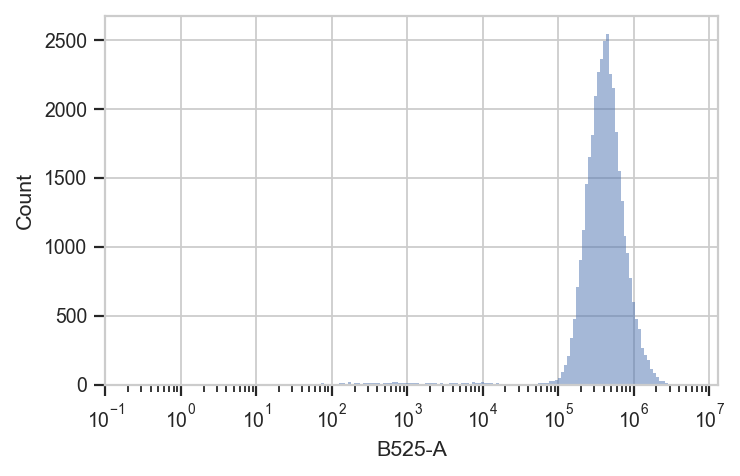

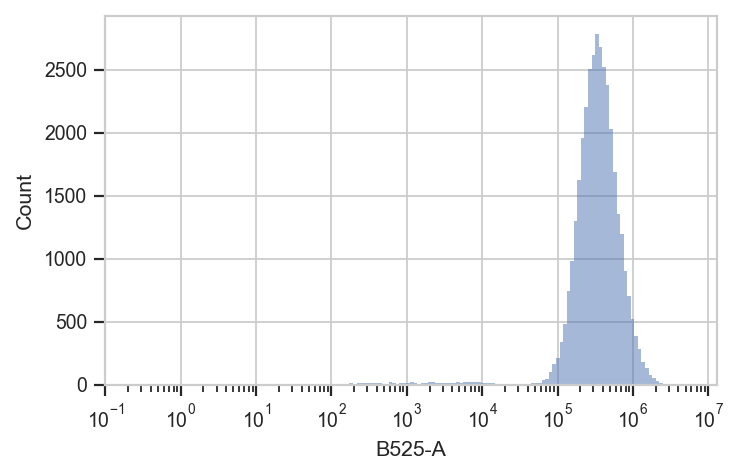

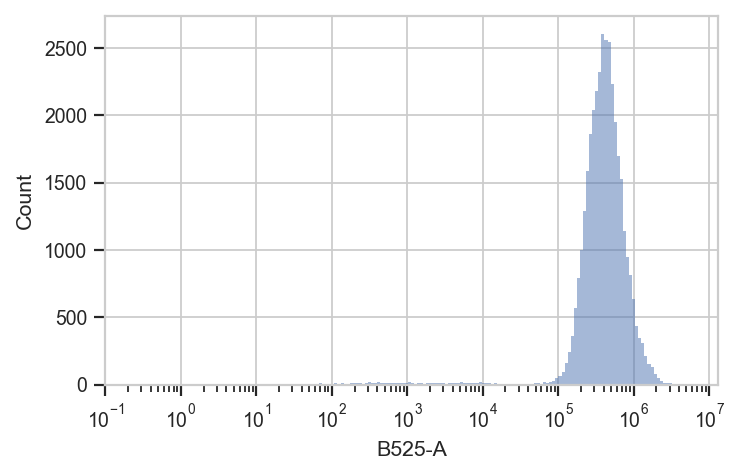

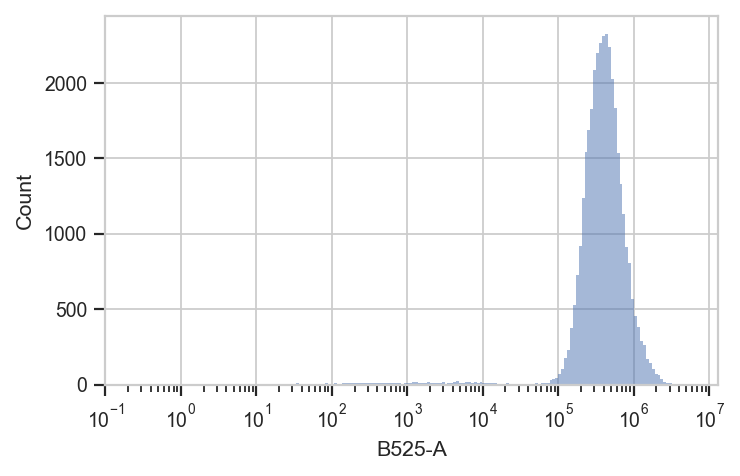

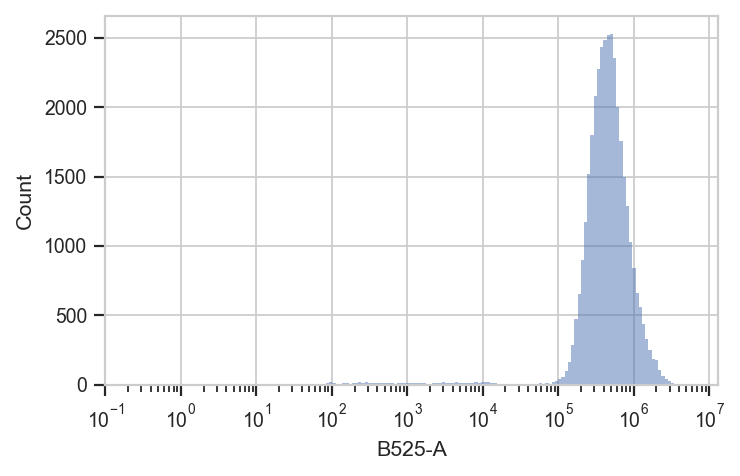

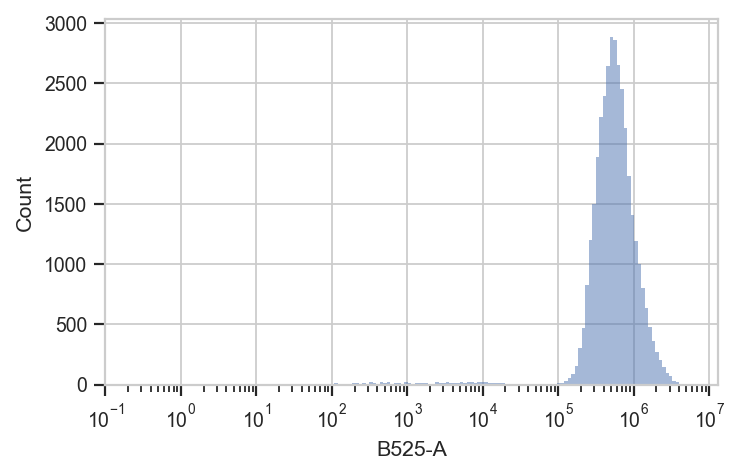

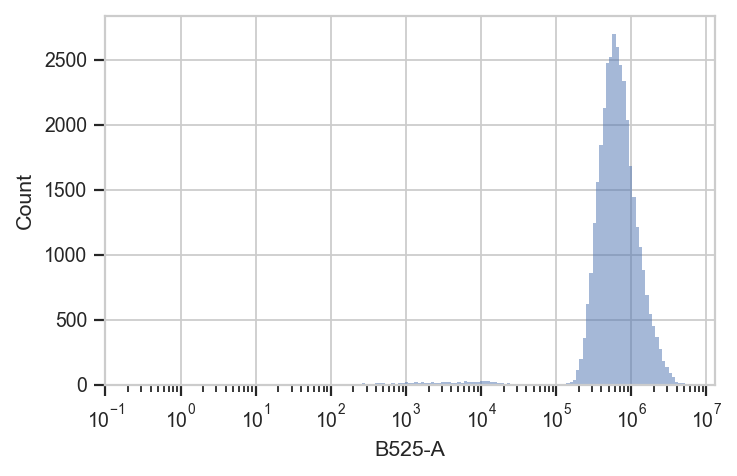

In [248]:
#gate plate1
#apply size threshold to remove debris
thresh = flow.ThresholdOp(name = "Size",
                          channel = "FSC-A",
                          threshold = 7*10e4)


##Check if fluorescent signal needs gating:
for i, CCM in CCM_conc_dict.items():
    
   # flow.ScatterplotView(xchannel = "FSC-A",
                  #   ychannel = "B525-A",
                  #   yscale = "log",
                  #   xscale = "log",
                  #   subset = "(Strain == 'ScCCM012')&(CCM=='"+str(i)+"')",
                  #   ).plot(plate1Gated, alpha = 0.01) #hue facet color according to gate
    
    flow.HistogramView(channel = "B525-A",
                scale = "log",
                subset = "(Strain == 'ScCCM012')&(CCM=='"+str(i)+"')").plot(plate1Gated)
    plt.show()
    
#It doensnt   
# we just apply the size gating:
plate1Gated = thresh.apply(plate1)

/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


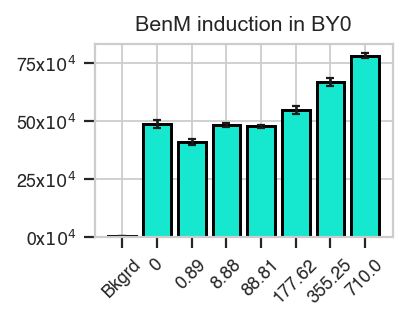

In [250]:
#plot Fluorescence Results
#choose plate
ex= plate1Gated



X=[]
Y=[]
Yerr=[]
colors=[]
tick_names =[]

metric='B525-A'
##add the control without fluorescent protein
strain = 'BY4741C-'
CCM =0
ABC=[]
for replicate in ['A','B','C']:
    i2plot =(ex.data['Strain'] == strain) & (ex.data['Size'] == True) & (ex.data['CCM'] == '0')  & (ex.data['Replicate'] == replicate)
    ABC.append(ex.data[i2plot][metric].mean())
Y.append(ABC)  
tick_names.append('Bkgrd')
colors.append(producer_color)

strain = 'ScCCM012' ## BenM(MP17_D08) strain at different [CCM]
metric='B525-A'
for i, CCM in CCM_conc_dict.items():
    ABC=[]
    for replicate in ['A','B','C']:
        i2plot =(ex.data['Strain'] == strain) & (ex.data['Size'] == True) & (ex.data['CCM'] == str(i))  & (ex.data['Replicate'] == replicate)
        
        ABC.append(ex.data[i2plot][metric].mean())
    X.append(CCM)
    colors.append(sensor_color)
    Y.append(ABC)
    tick_names.append(str(np.round(CCM_conc_dict[i],2))) 



Y = np.stack(Y)
H=1.6
fig, ax = plt.subplots(figsize=(3/2*H,H))


ax.bar(np.arange(len(Y)),Y.mean(axis=1),yerr=Y.std(axis=1), 
       color=colors,edgecolor=edgecolor,capsize=H,linewidth =H/1.2)


tick_loc = np.arange(8)
ax.xaxis.set_ticks(tick_loc)
#ax.set_title('BenM*  induction curve',fontsize=18)
ax.set_xticklabels(tick_names,rotation = 45, size=H*5, fontname='Helvetica')
#ax.set_ylabel('Fluorescence',fontsize=20, fontname='Helvetica')
#ax.set_ylim([0.0*10e5,0.42*10e5 ])
#ax.set_ylim([3.5,5.5 ])

ylabels = ax.get_yticks()
ylabels = [int(y)/10000 for y in ylabels]
ylabels= [str(int(y)) + 'x$10^4$' for y in ylabels]
ax.set_yticklabels(ylabels, size=H*5, fontname='Helvetica')

fig.set_size_inches(3/2*H,H)
ax.set_title('BenM induction in BY0')
plt.show()

In [34]:
#Compute significance P.values

print(X[2],stats.ttest_ind(Y[1].flatten(), Y[2], equal_var=True))
#the first 4 CCM conc are not significance we pool them and look at each conc in comparison to the pool
for i in range(1,8):
    print(X[i-1],stats.ttest_ind(Y[1:5].flatten(), Y[i], equal_var=True))


8.88125 Ttest_indResult(statistic=5.086790040264186, pvalue=0.007047226292792672)
0 Ttest_indResult(statistic=-1.0656204904364257, pvalue=0.30598721726453176)
0.888125 Ttest_indResult(statistic=2.5426720700712067, pvalue=0.024530252009974596)
8.88125 Ttest_indResult(statistic=-0.9071582828242729, pvalue=0.38083127065439637)
88.8125 Ttest_indResult(statistic=-0.5763059186438673, pvalue=0.5742513168117742)
177.625 Ttest_indResult(statistic=-3.8482856697048726, pvalue=0.00201406474073704)
355.25 Ttest_indResult(statistic=-9.381254874346196, pvalue=3.7555443221276846e-07)
710.0 Ttest_indResult(statistic=-14.935428888999512, pvalue=1.4559729057396305e-09)


## load HPLC data from 28.8.22

In [57]:
#For the HPLC bio replicate of figure 2B we use strains ScCCM13 and ScCCM14
#>> they have the same pathways and just a different biosensor version
#Sc_CCM013	BenM AroyB - YKO
#Sc_CCM014	BenM AroyB P146T -YKO
#Sc_CCM015	BenM( MP17_D08) AroyB -YKO
#Sc_CCM016	BenM( MP17_D08) AroyB P146T- YKO

In [235]:
##
data_path= 'raw_data/28.8.22_FACS_HPLC/'
Data_CCM=pd.read_excel(data_path+ 'HPLC28.8.22.xlsx', skiprows=6,sheet_name='CCM' ).astype(str)
#Data=Data.iloc[8:,:]
Data_CCM=Data_CCM.replace('n.a.',0)

# the samples were diluted 8X during sample prep. We remultiply back X8
back_dilute=8



## Load Flow Cyto Data from 28.8.22


In [236]:
#parse plate order:
order_path='Raw_Data/28.8.22_FACS_HPLC/FACS_X.8.22.csv'



order_plate2 = pd.read_csv(order_path, sep=',', skiprows=11)
order_plate2 = order_plate2.iloc[0:8,0:13]


In [237]:
#choose time point for figure
data_path_plate2 = 'Raw_Data/28.8.22_FACS_HPLC/72H/Plate2/'
file_name_plate2 ={}
#parse the name of the files   
for filename in os.listdir(data_path_plate2):
    if '_Sample' in filename:
        i = filename.index('_Sample') 
        row=alphabet[filename[0]]
        col= int(filename[1:i])
        file_name_plate2[(row,col)]= data_path_plate2+ filename


#parse plate2 data
tubes ={}
check ={}

for (r,c), path in file_name_plate2.items():

    #strain name
    strain= order_plate2.iloc[r-1][c][0:8] 
    replicate = order_plate2.iloc[r-1][c][8]
    ## CCM level
    if len(order_plate2.iloc[r-1][c])>9:
        level= str(order_plate2.iloc[r-1][c][-1])
    else:
        level= str(0)
    strain_num = str(strain[-2:])
    
    pathway=Pathway[strain_num ]
    sensor=Sensor[strain_num]
    ko = KO[strain_num]
    background = Background[strain_num]
  #  print(strain, pathway, sensor , ko)
    tubes[t]=flow.Tube(file = path ,conditions = { 'Strain': strain, 'CCM': level, 'Replicate': replicate,
                                                      'Pathway':pathway, 'Sensor':sensor, 'Background':background})
    check[t]=[strain,level,replicate,pathway,sensor]
    t+=1
    
    
tubes= [tubes[t] for t in tubes.keys()]     
import_op = flow.ImportOp(conditions = {'Strain': 'str','CCM': 'str','Replicate':'str','Pathway':'str','Sensor':'str','Background':'str'  }, tubes = tubes, events=12000)
plate2 = import_op.apply()

       

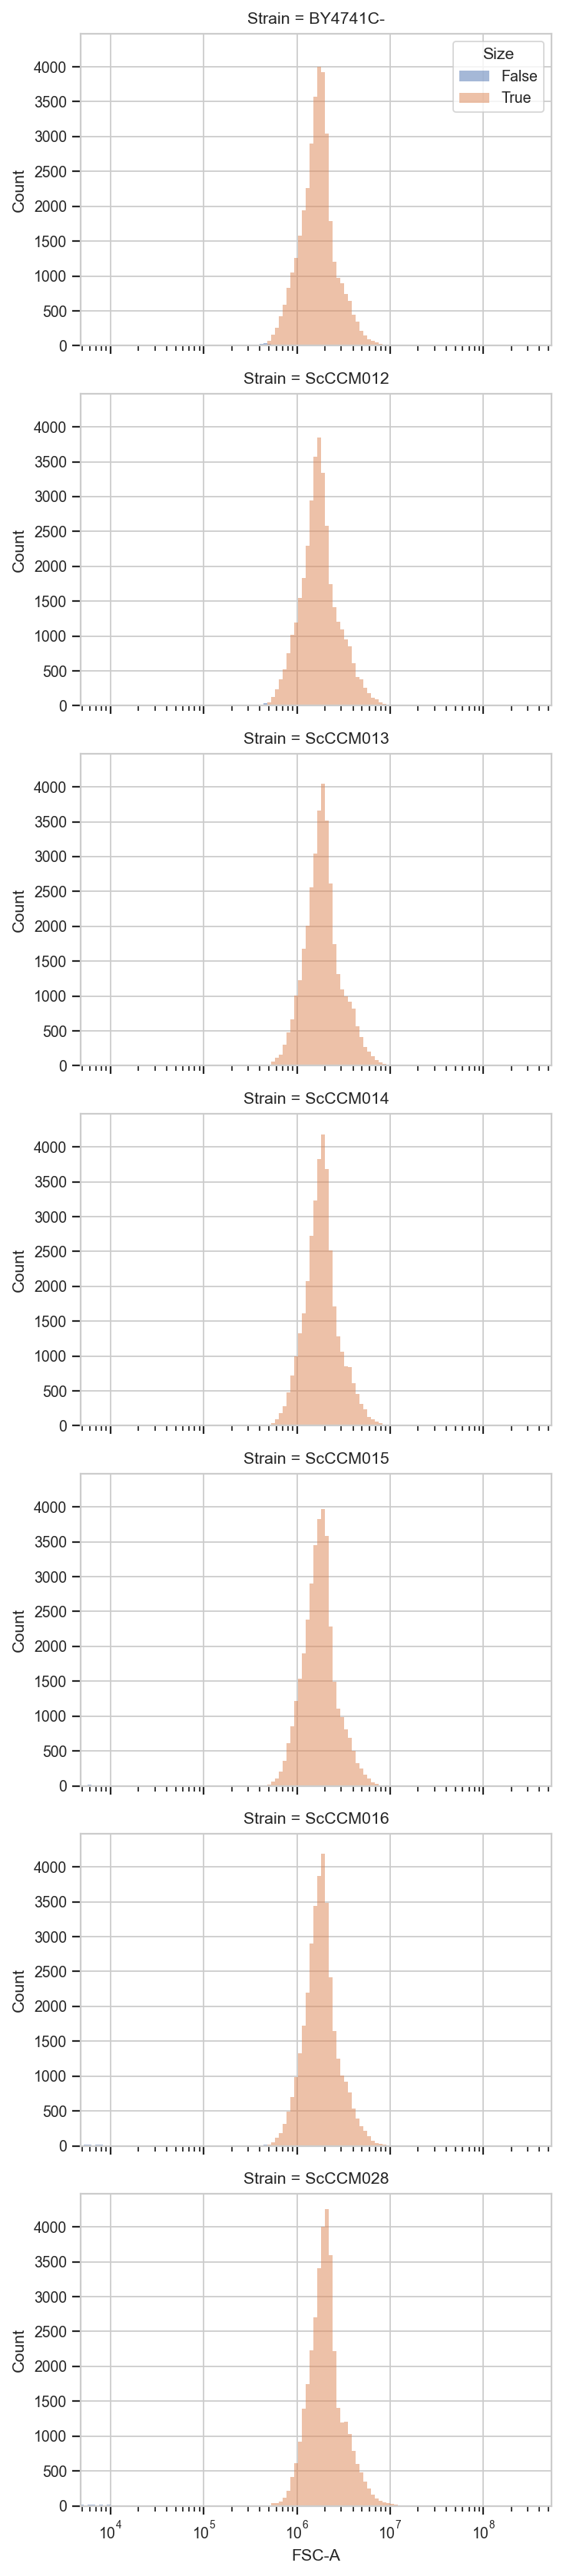

In [238]:
#gate plate2
#apply size threshold to remove debris
thresh = flow.ThresholdOp(name = "Size",
                          channel = "FSC-A",
                          threshold = 5*10e4)
plate2Gated = thresh.apply(plate2)


flow.HistogramView(channel = "FSC-A",
                scale = "log",
                yfacet = 'Strain',
                huefacet='Size').plot(plate2Gated)

/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


HPLC
variances: AroyB,AroyB*: 127.82917688888897 60.88017066666678
HPLC mean (mg/L): AroyB,AroyB*: 126.75733333333335 147.936
titer increase: 0.16708040560440937
Ttest_indResult(statistic=-2.1803032707083743, pvalue=0.09471239509958909)
FLOW
variances: AroyB,AroyB*: 112723628.82405919 8016108.699634831
Flow mean (A.U): AroyB,AroyB*: 267398.6368632409 274456.0652960111
flow increase: inf
Ttest_indResult(statistic=-0.9083147504769213, pvalue=0.4150880438620736)


/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/paucac/Documents/PhD/CAB/CRISPA/CRISPA_plates/ColonyAnalysisEnv/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: overflow encountered in double_scalars


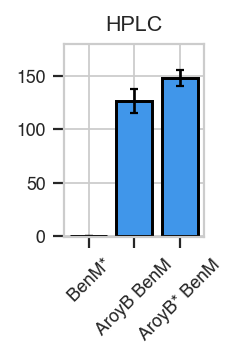

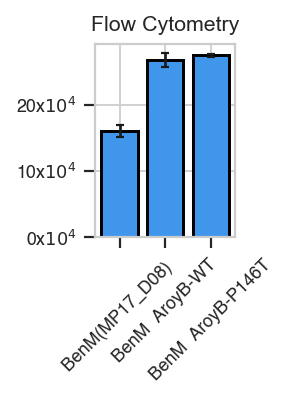

In [243]:
## plot HPLC data
X_HPLC=[]
Y_HPLC=[]
for s in [ 12,13,14]:#4,  3,5,6,4,7,8
    s= str(s)
    i= Data_CCM['Injection Name'].str.match(str(s)+'\w')
    X_HPLC.append(Pathway[s]+' '+Sensor[s])
    y =Data_CCM['Amount'][i].values.astype(str)
    #this one liner replaces commas to dots 
    y = [s.replace(',','.') if ',' in s else s for s in y ]

    Y_HPLC.append(y)
Y_HPLC = np.stack(Y_HPLC).astype(float)*back_dilute



H=1.6 #figure hight
fig, axs = plt.subplots(figsize=(1.7*H/2.4,H))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

default_color=[64/255,150/255,234/255]
edgecolor= [0,0,0]
axs.bar(np.arange(Y_HPLC.shape[0]) ,Y_HPLC.mean(axis=1),yerr=Y_HPLC.std(axis=1),
       color=default_color,edgecolor= edgecolor,linewidth=H/1.2,ecolor=edgecolor,capsize=H)
axs.xaxis.set_ticks(np.arange(Y_HPLC.shape[0]))
axs.tick_params(axis='both', which='major', labelsize=H*5)
#axs[0].set_ylabel('CCM (mg/L)')
axs.set_xticklabels(X_HPLC,rotation = 45, size=H*5, fontname='Helvetica')

axs.tick_params(axis='y',labelsize=H*5)
axs.set_title('HPLC')
axs.set_ylim([-1,180 ])
ylabels = axs.get_yticks()
ylabels = [str(int(y)) for y in ylabels]
axs.set_yticklabels(ylabels, size=H*5, fontname='Helvetica')


ex = plate2Gated

Y_Flow=[]
colors =[]
tick_names=[]

##add the BenM AroyB-WT strain
strain = 'ScCCM012'
CCM =0
ABC=[]
for replicate in ['A','B','C']:
    i2plot =(ex.data['Strain'] == strain) & (ex.data['Size'] == True) & (ex.data['CCM'] == '0')  & (ex.data['Replicate'] == replicate)
    ABC.append(ex.data[i2plot][metric].mean())
Y_Flow.append(ABC) 
colors.append(producer_color)
tick_names.append('BenM(MP17_D08) ')


##add the BenM AroyB-WT strain
strain = 'ScCCM013'
CCM =0
ABC=[]
for replicate in ['A','B','C']:
    i2plot =(ex.data['Strain'] == strain) & (ex.data['Size'] == True) & (ex.data['CCM'] == '0')  & (ex.data['Replicate'] == replicate)
    ABC.append(ex.data[i2plot][metric].mean())
Y_Flow.append(ABC) 
colors.append(producer_color)
tick_names.append('BenM  AroyB-WT')

##add the BenM AroyB-P146T strain
strain = 'ScCCM014'
CCM =0
ABC=[]
for replicate in ['A','B','C']:
    i2plot =(ex.data['Strain'] == strain) & (ex.data['Size'] == True) & (ex.data['CCM'] == '0')  & (ex.data['Replicate'] == replicate)
    ABC.append(ex.data[i2plot][metric].mean())
Y_Flow.append(ABC)  
tick_names.append('BenM  AroyB-P146T')
colors.append(producer_color)

Y_Flow = np.stack(Y_Flow)



fig, axs = plt.subplots(figsize=(1.7*H/2.4,H))

axs.bar(np.arange(len(Y_Flow)),Y_Flow.mean(axis=1),yerr=Y_Flow.std(axis=1), 
       color=colors,edgecolor=edgecolor,capsize=H,linewidth =H/1.2)
tick_loc = np.arange(3)

axs.xaxis.set_ticks(tick_loc)
axs.set_title('Flow Cytometry')
axs.set_xticklabels(tick_names,rotation = 45, size=H*5, fontname='Helvetica')
#axs[1].set_ylabel('Fluorescence (AU)')
ylabels = axs.get_yticks()
ylabels = [int(y)/10000 for y in ylabels]
ylabels= [str(int(y)) + 'x$10^4$' for y in ylabels]
axs.set_yticklabels(ylabels, size=H*5, fontname='Helvetica')
##perform t-test on HPLC

## check for equal variance
print('HPLC')
print('variances: AroyB,AroyB*:',Y_HPLC[1].var(),Y_HPLC[2].var())
# Perform the two sample t-test with equal variances
print('HPLC mean (mg/L): AroyB,AroyB*:',Y_HPLC[1].mean(),Y_HPLC[2].mean() )
print('titer increase:',(Y_HPLC[2].mean()-Y_HPLC[1].mean()) /Y_HPLC[1].mean()  )
print(stats.ttest_ind(a=Y_HPLC[1], b=Y_HPLC[2], equal_var=True))

##perform t-test on Flowcyto
print('FLOW')
## check for equal variance
print('variances: AroyB,AroyB*:',Y_Flow[1].var(),Y_Flow[2].var())
# Perform the two sample t-test with equal variances
print('Flow mean (A.U): AroyB,AroyB*:',Y_Flow[1].mean(),Y_Flow[2].mean() )
print('flow increase:',10**(Y_Flow[2].mean()-Y_Flow[1].mean())  )
print(stats.ttest_ind(a=Y_Flow[1], b=Y_Flow[2], equal_var=True))



## plot repeat of ARO2 KO Flow cyto and HPLC

In [121]:
##
data_path= 'Raw_Data/28.8.22_FACS_HPLC/'
Data_CCM=pd.read_excel(data_path+ 'HPLC28.8.22.xlsx', skiprows=6,sheet_name='CCM' ).astype(str)
#Data=Data.iloc[8:,:]
Data_CCM=Data_CCM.replace('n.a.',0)

# the samples were diluted 8X during sample prep. We remultiply back X8
back_dilute=8



HPLC t,p : -12.4103 0.00024236


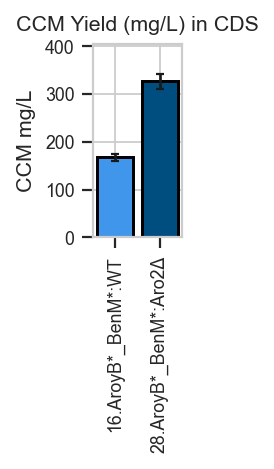

In [225]:

# the samples were diluted 10X during sample prep. We remultiply back X10
X_YKO=[]
Y_YKO=[]
colors =[ ]
for s in [ 16,28]:#4,  3,5,6,4,7,8
    s=str(s)
    i= Data_CCM['Injection Name'].str.match(str(s)+'\w')
    label= str(s)+'.'+Pathway[s]+'_'+Sensor[s]+':'+KO[s]
    X_YKO.append(label)
    y =Data_CCM['Amount'][i].values.astype(str)
    #this one liner replaces commas to dots 
    y = [s.replace(',','.') if ',' in s else s for s in y ]
    Y_YKO.append(y)


colors =[WT_color,Top_color]
        
Y_YKO = np.stack(Y_YKO).astype(float)*back_dilute

H=1.6 #figure hight
fig, ax = plt.subplots(figsize=(0.66*1.625*H/2.4,H))


ax.bar(np.arange(Y_YKO.shape[0]) ,Y_YKO.mean(axis=1),yerr=Y_YKO.std(axis=1),
       color=colors,edgecolor=edgecolor,capsize=H,linewidth=H/1.2)
ax.xaxis.set_ticks(np.arange(Y_YKO.shape[0]))
ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_ylabel('CCM mg/L')
ax.set_xticklabels(X_YKO,rotation = 90, size=H*5)

ax.tick_params(axis='y',labelsize=H*5)

ax.set_title('CCM Yield (mg/L) in CDS')
ax.set_ylim([0,405])

t,p = stats.ttest_ind(a=Y_YKO[0,:], b=Y_YKO[1,:], equal_var=True)
print('HPLC t,p :',np.round(t,4),np.round(p,8))


## Now plot the flow_cytometry repeat

In [ ]:
#code from CCM_FACS.ipynb

In [138]:
#parse plate order:

order_path='Raw_Data/28.8.22_FACS_HPLC/FACS_X.8.22.csv'
order_plate2 = pd.read_csv(order_path, sep=',', skiprows=11)
order_plate2 = order_plate2.iloc[0:8,0:13]


#parse flow cyto data file names

data_path_plate2 = 'Raw_Data/28.8.22_FACS_HPLC/72H/Plate2/'
file_name_plate2 ={}
for filename in os.listdir(data_path_plate2):
    if '_Sample' in filename:
        i = filename.index('_Sample') 
        row=alphabet[filename[0]]
        col= int(filename[1:i])
        file_name_plate2[(row,col)]= data_path_plate2+ filename

In [222]:
tubes ={}
check ={}
t=0
for (r,c), path in file_name_plate2.items():

    #strain name
    strain= order_plate2.iloc[r-1][c][0:8] 
    replicate = order_plate2.iloc[r-1][c][8]
    

    ## CCM level
    if len(order_plate2.iloc[r-1][c])>9:
        level= str(order_plate2.iloc[r-1][c][-1])
    else:
        level= str(0)
    strain_num = str(strain[-2:])
    
    pathway=Pathway[strain_num ]
    sensor=Sensor[strain_num]
    ko = KO[strain_num]
    background = Background[strain_num]
  #  print(strain, pathway, sensor , ko)
    tubes[t]=flow.Tube(file = path ,conditions = { 'Strain': strain, 'CCM': level, 'Replicate': replicate,
                                                      'Pathway':pathway, 'Sensor':sensor, 'Background':background})
    check[t]=[strain,level,replicate,pathway,sensor]
    t+=1
    
    
tubes= [tubes[t] for t in tubes.keys()]     
import_op = flow.ImportOp(conditions = {'Strain': 'str','CCM': 'str','Replicate':'str','Pathway':'str','Sensor':'str','Background':'str'  }, tubes = tubes, events=12000)
plate2 = import_op.apply()





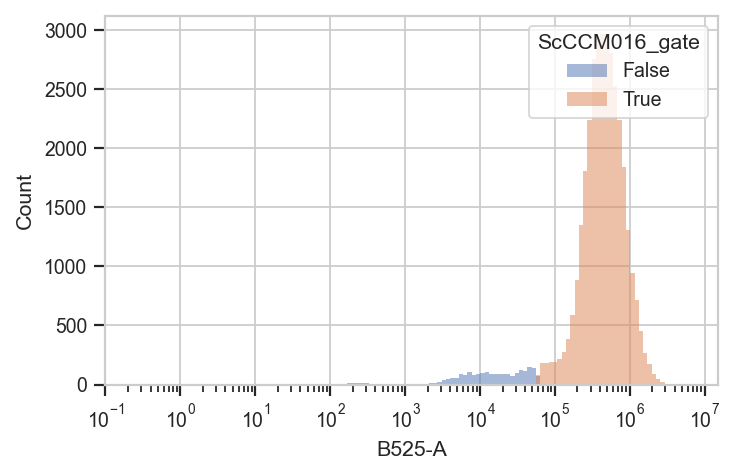

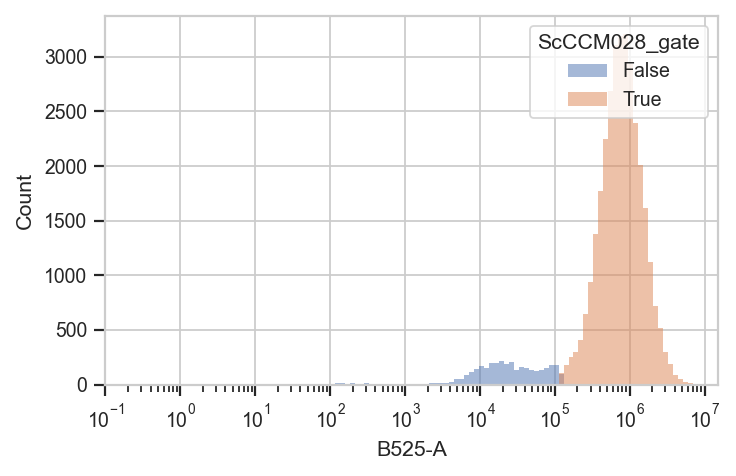

In [194]:
thresh = flow.ThresholdOp(name = "Size",
                          channel = "FSC-A",
                          threshold = 5*10e4)

plate2Gated = thresh.apply(plate2)



ex= plate2Gated
metrics=['Strain', 'CCM', 'Pathway', 'Sensor']

#we list all individual conditions to define a gate for all individual tubes (same for all replicates)
conditions= np.unique(ex.data[metrics].values.astype(str), axis=0)


## Create fluo gates for each strain

gate= (plate2Gated.data['B525-A']>60000)
plate2Gated.add_condition('ScCCM016_gate','bool', gate)
gate= (plate2Gated.data['B525-A']>120000)
plate2Gated.add_condition('ScCCM028_gate','bool', gate)


##Check correct gating here:
for strain in ['ScCCM016','ScCCM028']:
    flow.HistogramView(
                     channel = "B525-A",
                     scale = "log",
                     subset = "(Strain == '"+strain+"')",
                     huefacet=strain+'_gate').plot(plate2Gated)
    plt.show()
    

    
    

"fig, ax = plt.subplots(figsize=(4/3,3))\n\n\nax.bar(np.arange(len(Y)),Y.mean(axis=1),yerr=Y.std(axis=1), color=colors,edgecolor=edgecolor,capsize=5,linewidth =2)\n\nylabels = ax.get_yticks()\n#ax.set_ylim([0*10e5,10*10e4 ])\n\nprint(ylabels)\nylabels = [int(y)/10000 for y in ylabels]\nylabels= [str(int(y)) + 'x$10^4$' for y in ylabels]\nax.set_yticklabels(ylabels, size=14)\n\ntick_loc = np.arange(len(Y))\nax.xaxis.set_ticks(tick_loc)\nax.set_xticklabels(tick_names,rotation = 90)\nax.set_ylabel('Fluorescence')\nt,p = stats.ttest_ind(a=Y[0,:], b=Y[0,:], equal_var=True)\nprint('HPLC t,p :',np.round(t,4),np.round(p,8))\n#ax.set_xlim([-0.5,13])"

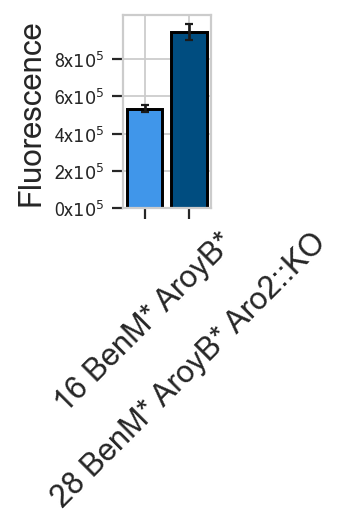

In [221]:
#plot Fluorescence Results
#choose plate
ex= plate2Gated

X=[]
Y=[]
Yerr=[]
tick_names=[]
colors=[]
 ## BenM(MP17_D08) strain at different [CCM]
metric='B525-A'



##add the control  BenM(MP17_D08) AroY.B_P146T
strain = 'ScCCM016'
CCM =0
ABC=[]
for replicate in ['A','B','C']:
    i2plot =(ex.data['Strain'] == strain) & (ex.data['Size'] == True)  & (ex.data['Replicate'] == replicate)
    i2plot = i2plot & (ex.data['ScCCM016_gate'] == 1)
    ABC.append(ex.data[i2plot][metric].mean())
Y.append(ABC)  
tick_names.append('16 BenM* AroyB*')
colors.append(WT_color)




##add the BenM(MP17_D08) AroY.B_P146T  Aro2 KO 
strain = 'ScCCM028'
CCM =0
ABC=[]
for replicate in ['A','B','C']:
    i2plot =(ex.data['Strain'] == strain) & (ex.data['Size'] == True)  & (ex.data['Replicate'] == replicate)
    i2plot = i2plot & (ex.data['ScCCM028_gate'] == 1)
    
    ABC.append(ex.data[i2plot][metric].mean())
Y.append(ABC)  
tick_names.append('28 BenM* AroyB* Aro2::KO')
colors.append(Top_color)



Y = np.stack(Y)


H=1.6 #figure hight
fig, ax = plt.subplots(figsize=(0.66*1.625*H/2.4,H))

colors=[default_color,Top_color]

Bars_mean=[np.mean(x) for x in Y]
Bars_std=[np.std(x) for x in Y]
tick_loc = np.arange(len(Bars_mean))
ax.bar(tick_loc,Bars_mean,yerr=Bars_std, color= colors,edgecolor=edgecolor,capsize=H,linewidth =H/1.2)

ax.xaxis.set_ticks(tick_loc)
ax.set_title('')
ax.set_xticklabels(tick_names,rotation = 45, size=H)



#ax.set_ylim([0,50300000])
ax.set_ylabel('Fluorescence', size=H)
#ax.set_ylim([3*10**7,5.3*10**7 ])

ax.yaxis.set_ticks(np.arange(0*10e5,10*10e4 , 0.2*10**6))
ylabels = ax.get_yticks()
ylabels = [int(y)/100000 for y in ylabels]
ylabels= [str(int(y)) + 'x$10^5$' for y in ylabels]

ax.set_yticklabels(ylabels, size=H*5)


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() ):
    item.set_fontsize(14)
'''fig, ax = plt.subplots(figsize=(4/3,3))


ax.bar(np.arange(len(Y)),Y.mean(axis=1),yerr=Y.std(axis=1), color=colors,edgecolor=edgecolor,capsize=5,linewidth =2)

ylabels = ax.get_yticks()
#ax.set_ylim([0*10e5,10*10e4 ])

print(ylabels)
ylabels = [int(y)/10000 for y in ylabels]
ylabels= [str(int(y)) + 'x$10^4$' for y in ylabels]
ax.set_yticklabels(ylabels, size=14)

tick_loc = np.arange(len(Y))
ax.xaxis.set_ticks(tick_loc)
ax.set_xticklabels(tick_names,rotation = 90)
ax.set_ylabel('Fluorescence')
t,p = stats.ttest_ind(a=Y[0,:], b=Y[0,:], equal_var=True)
print('HPLC t,p :',np.round(t,4),np.round(p,8))
#ax.set_xlim([-0.5,13])'''


array([[551272.46942382, 507496.59164589, 537739.88680437],
       [999251.93995954, 928413.3627015 , 899525.17146853]])

In [198]:
## check for equal variance
print('FLow cytometry')
# Perform the two sample t-test with equal variances


print('WT — Aroy2',stats.ttest_ind(a=Y[0], b=Y[1], equal_var=True))

FLow cytometry
WT — Aroy2 Ttest_indResult(statistic=-12.689402483014229, pvalue=0.00022213464856492415)


## OEx hit confirmation repeat

## BnA Correction figure

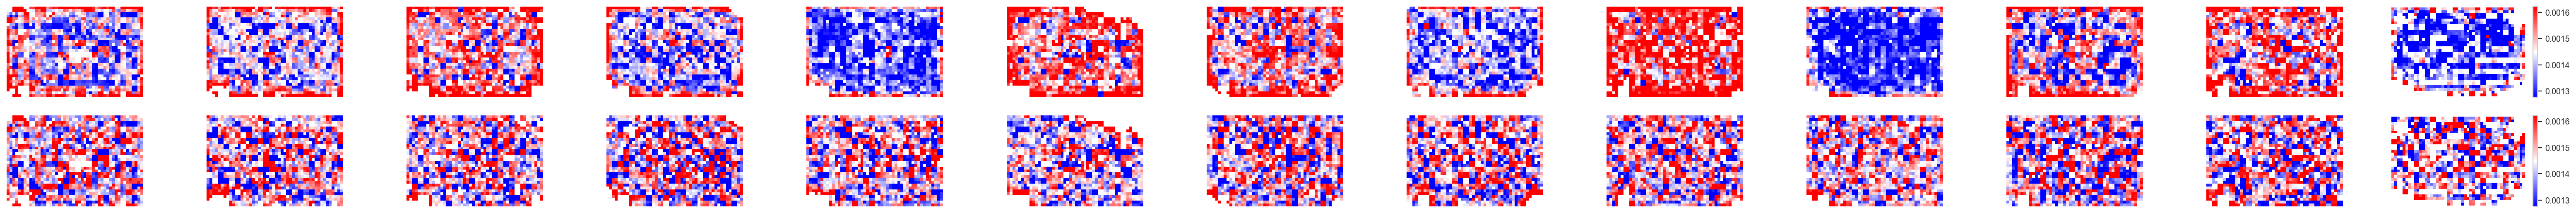

In [4]:
CCM19 = pd.read_csv('raw_data/screen_data/QD19.csv', sep=',')

DF= CCM19.copy()

fig, axs= plt.subplots(2, 13,figsize=(50,4))
axs=axs.flatten()
for p in range(13):
    metric='mean_intensity.48'
    before= DF.loc[DF['plate']== p, metric]
    after= DF.loc[DF['plate']==p,'corrected_' + metric]

    #creates same vmax vmin for all plates:
    vmax=DF.loc[:, metric].mean()+DF.loc[:, metric].std()
    vmin=DF.loc[:, metric].mean()-DF.loc[:, metric].std()
    pos=axs[p].imshow(before.values.reshape((32,48)), vmin=vmin, vmax= vmax,cmap='bwr')
    
    
    vmax=DF.loc[:,'corrected_' + metric].mean()+DF.loc[:, 'corrected_' +metric].std()
    vmin=DF.loc[:, 'corrected_' +metric].mean()-DF.loc[:,'corrected_' + metric].std()
    pos=axs[p+13].imshow(after.values.reshape((32,48)), vmin=vmin,vmax=vmax,cmap='bwr')
    
    
    
    axs[p].set_axis_off()
    axs[p+13].set_axis_off()
fig.colorbar(pos, ax=axs[p])
fig.colorbar(pos, ax=axs[p+13])
plt.show()


"for i in range(0,2):    \n    axs[i].tick_params(axis='both', which='major', labelsize=5)\n   \n    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] + axs[i].get_xticklabels()):\n        print(item)\n        item.set_fontsize(14)"

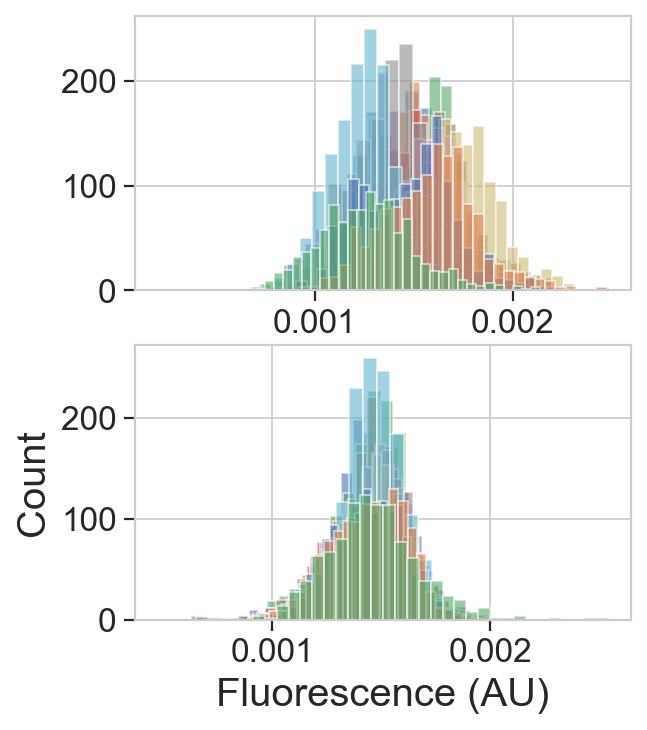

In [5]:


fig, axs= plt.subplots(2, 1,figsize=(4,5))
axs=axs.flatten()
for p in range(13):
    metric='mean_intensity.48'
    before= DF.loc[DF['plate']== p, metric]
    after= DF.loc[DF['plate']==p,'corrected_' + metric]

    pos=axs[0].hist(before.values,30, alpha=0.6)
    pos=axs[1].hist(after.values,30, alpha=0.6)
    axs[1].set_xlabel('Fluorescence (AU)',fontsize=18)
    #axs[0].set_xlim([0, 350])
    #axs[1].set_xlim([0, 350])

    
    axs[1].set_ylabel('Count',fontsize=18)
   # axs[0].set_title(metric)

    
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=15)

    
'''for i in range(0,2):    
    axs[i].tick_params(axis='both', which='major', labelsize=5)
   
    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] + axs[i].get_xticklabels()):
        print(item)
        item.set_fontsize(14)'''

## Plot compiled HPLC  vs CRI-SPA score data

In [2]:
CRISPA_KO = pd.read_csv('raw_data/screen_data/GA16_19.csv',
                       sep=',')
CRISPA_OEx = pd.read_csv('raw_data/screen_data/GA20.csv',sep=',')

Compiled = pd.read_csv('Raw_Data/HPLC_combined_data/HPLC_combined.csv', sep=',')

#VMA16 is called PPA1 we change this:
CRISPA_KO.loc[CRISPA_KO.gene == 'PPA1','gene']='VMA16'
#HEM25 is called YDL119C we change this:
CRISPA_KO.loc[CRISPA_KO.gene == 'YDL119C','gene'] = 'HEM25'


CRISPA_OEx.loc[CRISPA_OEx.gene=='Control-his3d-SW', 'gene'] = 'WT'
#create a dict translating HPLC name to crispa name


metrics = ['corrected_mean_intensity.48','corrected_area.48']
DFs=[CRISPA_KO, CRISPA_OEx]
for metric in metrics:
    for DF in DFs:
        #we first correct the std using the screens mean
        #we then correct the mean
        DF[metric +'_std'] = (DF[metric+'_std'])/DF[metric+'_mean'].std()
        DF[metric +'_mean'] = (DF[metric+'_mean']-DF[metric+'_mean'].mean())/DF[metric+'_mean'].std()
  

# this maps the name we used in our HPLC experiments to the name in the CRI-SPA DF
strain2crispa= {}
strain2crispa['ADE12'] = 'ADE12'
strain2crispa['AIM22'] = 'AIM22'
strain2crispa['ARG5,6'] = 'ARG5,6'

strain2crispa['LPD1'] = 'LPD1'
strain2crispa['LYS14'] = 'LYS14'
strain2crispa['MET14'] = 'MET14'
strain2crispa['PDA1'] = 'PDA1'
strain2crispa['SNF7'] = 'SNF7'
strain2crispa['VPS20'] = 'VPS20'

strain2crispa['FLO10'] = 'FLO10'
strain2crispa['YIL059C'] = 'YIL059C'
strain2crispa['CCM19WT'] = 'WT'
strain2crispa['ScCCM74_LPD1'] = 'LPD1'
strain2crispa['ScCCM16'] = 'WT'


strain2crispa['ScCCM72'] = 'VPS20'
strain2crispa['ScCCM73'] = 'PDA1'
strain2crispa['ScCCM74'] = 'LPD1'
strain2crispa['ScCCM75'] = 'AIM22'
strain2crispa['ScCCM77'] = 'LYS14'
strain2crispa['ScCCM78'] = 'MET14'

strain2crispa['ScCCM88'] = 'GCR1'
strain2crispa['ScCCM89'] = 'MET6'
strain2crispa['ScCCM90'] = 'GLO4'
strain2crispa['ScCCM91'] = 'GSH1'
strain2crispa['ScCCM92'] = 'TDH3'
strain2crispa['ScCCM94'] = 'FOB1'
strain2crispa['ScCCM95'] = 'RIB5'
strain2crispa['ScCCM96'] = 'YLL058W'
strain2crispa['MET14.CCM19']= 'MET14_KO'


### We create a number of dictionaries mapping each HPLC to its distinctive parameters

#define experiment names
experiments ={ '23.3.17':'23.3.17','23.1.24CCM19':'23.1.24','23.1.24CCM16':'23.1.24',
              '23.2.20':'23.2.20','23.3.24':'23.3.24','23.5.1rep1':'23.5.1','23.5.1rep2':'23.5.1',
              '23.5.22':'23.5.22','23.5.26OEx':'23.5.26','23.5.26KO':'23.5.26'}
#define experiment dilution factor
dilution_factors ={ '23.1.24CCM16':4,'23.1.24CCM19':4,'23.2.20':4,'23.3.17':8,'23.3.24':8,
                  '23.5.1rep1':4,'23.5.1rep2':4,'23.5.22':2,'23.5.26OEx':2,'23.5.26KO':2}

#define strains tested in each experiment
tested_strains= {}
tested_strains['23.3.17']=['ScCCM16', 'LYS14','ARG5,6','PDA1', 'SNF7', 'VPS20']
tested_strains['23.3.24']=['ScCCM16', 'LYS14','ARG5,6','PDA1', 'SNF7', 'VPS20']

tested_strains['23.1.24CCM19']=['ScCCM16','ARG5,6','LPD1','AIM22', 'SNF7', 'ADE12']
tested_strains['23.1.24CCM16']=['ScCCM16','ARG5,6','LPD1','AIM22', 'SNF7', 'ADE12']
tested_strains['23.5.22']=['ScCCM16','ScCCM88','ScCCM89','ScCCM90','ScCCM91','ScCCM92','ScCCM94'
                          ,'ScCCM95','ScCCM96']
tested_strains['23.5.26OEx']=['ScCCM16','ScCCM88','ScCCM89','ScCCM90','ScCCM91','ScCCM94'
                          ,'ScCCM95','ScCCM96']
tested_strains['23.5.26KO']= ['ScCCM16','ARG5,6','LPD1','AIM22','LYS14','MET14','PDA1'] #'ScCCM92'
tested_strains['23.2.20']= ['ScCCM16','ARG5,6','PDA1','LYS14','LPD1','AIM22', 'SNF7', 'ADE12','VPS20'] #'ScCCM92'


#define experiment colors
colors ={ '23.1.24CCM16':[22/255,221/255,190/255],
         '23.1.24CCM19':[86/255,193/255,255/255],
         '23.2.20':[241/255,91/255,181/255],
         '23.3.17':[0/255,77/255,128/255],
         '23.3.24':[254/255,228/255,64/255],
        '23.5.1rep1':[1,1,0],
        '23.5.1rep2':[1,0.5,0],
        '23.5.22':[1,0,0],
        '23.5.26OEx':[0.8,0.2,0],
        '23.5.26KO':[0.8,0,0.5]
        }


#define experiment colors
colors ={ '23.1.24CCM16':[22/255,221/255,190/255],
         '23.1.24CCM19':[86/255,193/255,255/255],
         '23.2.20':[241/255,91/255,181/255],
         '23.3.17':[0/255,77/255,128/255],
         '23.3.24':[254/255,228/255,64/255],
        '23.5.1rep1':[1,1,0],
        '23.5.1rep2':[1,0.5,0],
        '23.5.22':[1,0,0],
        '23.5.26OEx':[0.8,0.2,0],
        '23.5.26KO':[0.8,0,0.5]
        }

#define strains tested in each experiment
CRISPA_screen= {'23.1.24CCM16':CRISPA_KO,'23.1.24CCM19':CRISPA_KO,'23.2.20':CRISPA_KO,'23.3.17':CRISPA_KO,'23.3.24':CRISPA_KO,
                  '23.5.1rep1':CRISPA_KO,'23.5.1rep2':CRISPA_KO,
                '23.5.22':CRISPA_OEx,'23.5.26OEx':CRISPA_OEx,'23.5.26KO':CRISPA_KO}



In [3]:
#### from scipy.stats import  ttest_ind




X = []
Y =[]
Xerr=[]
Yerr=[]
G=[]
S=[]
x_metric = 'corrected_mean_intensity.48'
y_metric =  'CCM'


Y_DF = Compiled.copy()


Not_in_CRISPA =[]
Run=[]
X=[]
Y=[]
C=[] #store colors
G=[] #store p value
M=[] #runs means
R=[]
P=[]
PCC=[]
run2plot=['23.3.17','23.3.24','23.2.20','23.1.24CCM19','23.1.24CCM16']#'23.3.17', '23.1.24CCM19', '23.1.24CCM16','23.5.22','23.5.26OEx',
for e_n in run2plot: # ['23.1.24CCM16','23.1.24CCM19','23.2.20','23.3.17','23.3.24']:# 
    E = experiments[e_n]
    print(e_n)
    X_DF= CRISPA_screen[e_n].copy()
    # create sub lists to store each experiment
    X_=[] 
    Y_=[]
    Xerr_=[] 
    Yerr_=[]
    C_=[] #color
    G_=[] #gene
    P_=[] #values
    #used for p-value calculation
    i_select = (Y_DF.gene.str.contains('ScCCM16')) & (Y_DF.run== e_n)
    WT_score = Y_DF[i_select][y_metric]*dilution_factors[e_n]
    #compute the runs mean, excluding standards
    i_select =  (Y_DF.run== e_n) & (Y_DF.gene.str.contains('mg')==0)& (Y_DF.gene.str.contains('BLANK')==0)
    run_mean= (Y_DF[i_select][y_metric]*dilution_factors[e_n]).mean()
    M.append(run_mean)
    R.append(e_n)

   # for gene in strain2crispa.keys():
    for gene in tested_strains[e_n]:
    
        x= X_DF[X_DF.gene == strain2crispa[gene] ][x_metric+'_mean'].values[0]
        xerr= X_DF[X_DF.gene == strain2crispa[gene ]][x_metric+'_std'].values[0]
        i_select = (Y_DF.gene.str.contains(gene)) & (Y_DF.run== e_n)
        y=Y_DF[i_select][y_metric].mean()*dilution_factors[e_n]#/WT_score.mean()
        yerr = Y_DF[i_select][y_metric].std()*dilution_factors[e_n]#/WT_score.mean()

        gene_score = Y_DF[i_select][y_metric]
        #we do a one sided t-test to check if bottom genes are significantly less and top genes are significantly more 
        #less: for (a,b) test that a is less than b
        #greater: for (a,b) test that a greater than b
        alternative = 'less' if gene in ['ADE12','SNF7','VPS20'] else 'greater'
        
        t, p = ttest_ind(gene_score,WT_score,alternative=alternative)
        X_.append(x)
        Y_.append(y)
        Xerr_.append(xerr)
        Yerr_.append(yerr)    

        G_.append(strain2crispa[gene])
        P_.append(np.round(p,4))
    Y.append(Y_)
    Yerr.append(Yerr_)
    X.append(X_)
    Xerr.append(Xerr_)
    G.append(G_)
    C.append(colors[e_n])
    P.append(P_)
    
    
    

23.3.17
23.3.24
23.2.20
23.1.24CCM19
23.1.24CCM16


[1.3453615070152756, 3.347826786691246, 3.4964764349479682, 4.316755806405646, -4.028456468713535, -3.3633199212994658] [273.81333333333333, 444.5786666666666, 447.88000000000005, 441.60266666666666, 206.94133333333332, 198.75466666666668] ['WT', 'LYS14', 'ARG5,6', 'PDA1', 'SNF7', 'VPS20']
0.942
R:0.94, p<0.05
[1.3453615070152756, 3.347826786691246, 3.4964764349479682, 4.316755806405646, -4.028456468713535, -3.3633199212994658] [132.91466666666668, 104.98666666666666, 113.95466666666668, 139.78133333333335, 47.17066666666667, 35.858666666666664] ['WT', 'LYS14', 'ARG5,6', 'PDA1', 'SNF7', 'VPS20']
0.908
R:0.91, p<0.05
[1.3453615070152756, 3.4964764349479682, 4.316755806405646, 3.347826786691246, 3.448877869937142, 2.442385145396653, -4.028456468713535, -3.1538111810265996, -3.3633199212994658] [181.70533333333333, 160.77733333333333, 140.212, 154.732, 132.00266666666667, 143.97733333333335, 79.668, 64.55733333333333, 64.90666666666667] ['WT', 'ARG5,6', 'PDA1', 'LYS14', 'LPD1', 'AIM22', '

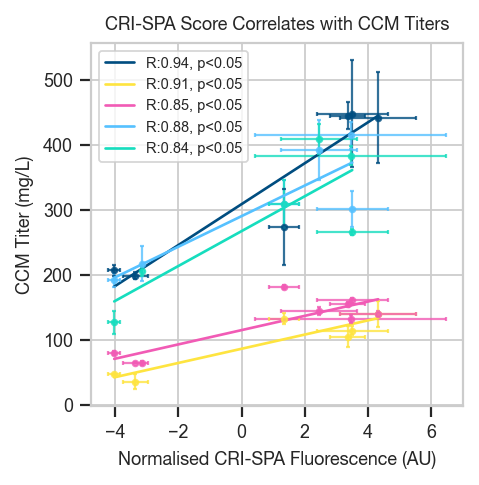

In [7]:
H =3
fig, ax = plt.subplots(figsize=(H,H))

for i,e_n in enumerate(run2plot):#,'23.3.17', '23.1.24CCM19','23.1.24CCM16','23.5.26OEx',]):

    
    
   # for gene, x,y,p in zip(G[i],X[i],Y[i], P[i]):
     #   if (np.isnan(x)==0) & (np.isnan(y)==0):
    #            ax.annotate(gene, (x,y),fontsize=12,
       #                     arrowprops =  arrowprops)
             
    
    #plot linear fits
    
    i_nan = np.isnan(np.vstack([X[i],Y[i]])).any(axis=0)==0
    print(X[i],Y[i],G[i])
    pcc= np.round(stats.pearsonr(np.stack(X[i])[i_nan], np.stack(Y[i])[i_nan])[0],3)
    slope, intercept,  R2, p_value, std_err = stats.linregress(np.stack(X[i])[i_nan],np.stack(Y[i])[i_nan])
    # prepare a few things for the plotting
    c= colors[e_n]  #color
    label = 'R:' +str(np.round(R2,2)) +', p<0.05'#+str(np.round(p_value,3))#legend
    print(pcc)
    print(label)
    ## plot linear fit:
    ax.plot([min(X[i]),max(X[i])],[min(X[i])*slope+intercept,max(X[i])* slope+intercept], color=c, label=label )
    ax.errorbar(X[i],Y[i] ,xerr=Xerr[i], yerr=Yerr[i], fmt="." ,color=c,
                 capsize=1, elinewidth=1, markeredgewidth=1, alpha=0.8)
ax.set_xlabel('Normalised CRI-SPA Fluorescence (AU)',fontsize=H*2.7,fontname='Helvetica Neue')
ax.set_ylabel('CCM Titer (mg/L)',fontsize=H*2.7,fontname='Helvetica Neue')
ax.set_title('CRI-SPA Score Correlates with CCM Titers',fontsize=H*2.7,fontname='Helvetica Neue')

#ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='x',labelsize=H*2.7)
ax.tick_params(axis='y',labelsize=H*2.7)
ax.legend(fontsize=H*2.2)

## Plot replicate HPLC validation of top OEx hits

In [11]:
strain2gene={}
strain2gene['ScCCM88'] = 'GCR1'
strain2gene['ScCCM89'] = 'MET6'
strain2gene['ScCCM90'] = 'GLO4'
strain2gene['ScCCM91'] = 'GSH1'
strain2gene['ScCCM92'] = 'TDH3'
strain2gene['ScCCM94'] = 'FOB1'
strain2gene['ScCCM95'] = 'RIB5'
strain2gene['ScCCM96'] = 'YLL058W'
strain2gene['ScCCM97'] = 'UK'
strain2gene['ScCCM16'] = 'WT'
strain2gene['ScCCMbio16'] = 'IGNORE'
strain2gene['MET14.CCM19']= 'MET14_KO'
strain2gene['MET14']= 'MET14'
strain2gene['LPD1']= 'LPD1'
strain2gene['AIM22']= 'AIM22'
strain2gene['ARG5,6']= 'ARG5,6'
strain2gene['LYS14']= 'LYS14'
strain2gene['PDA1']= 'PDA1'

#reverse dict
gene2strain={}
for s, g in strain2gene.items():
    gene2strain[g]=s




data_path= 'raw_data/23.5.22_HPLC/'
HPLC_map = pd.read_csv(data_path+ 'HPLC_map.csv' ).astype(str)
HPLC_map=HPLC_map.iloc[:8, 1:13]


HPLC_map =  HPLC_map.values.reshape(-1)[0:96]


HPLC_map=HPLC_map[HPLC_map!='nan']


In [13]:

data_path= 'raw_data/23.5.22_HPLC/'
HPLC_map = pd.read_csv(data_path+ 'HPLC_map.csv' ).astype(str)
HPLC_map=HPLC_map.iloc[:8, 1:13]


HPLC_map =  HPLC_map.values.reshape(-1)[0:96]

HPLC_map=HPLC_map[HPLC_map!='nan']


strains = [g[:g.index('_')] if '_' in g else g for g in HPLC_map]
genes = [strain2gene[g] if ('std' not in g) and ('BLANK' not in g)  else g for g in strains]


# we incubated all wells for 6 days (except for ScCCM16_A.72H and ScCCM95 which were incubated for 72H)
modif_type = ['KO' if 'MET14' in g else 'OEx' for g in HPLC_map] #solid colony or liquid culture


dilution_factor =2

##load data

columns =['No' ,'Injection_Name','Ret_Time' ,'Area' ,'Height' ,'Amount' ,'Rel_Area','Peak_Type'  ]
hplc_file ='HPLC23.5.22_UV_VIS_4.xlsx'
HPLC_CCM=pd.read_excel(data_path+ hplc_file, skiprows=14, names=columns).astype(str)
HPLC_CCM=HPLC_CCM.iloc[:95,:]
HPLC_CCM=HPLC_CCM.replace('n.a.',0)
HPLC_CCM = HPLC_CCM[HPLC_CCM!='']
# the samples were diluted 8X during sample prep. We remultiply back X8
back_dilute=8


#alphabet match
alphabet={}
for i,L in enumerate('ABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    alphabet[L] = i +1
    

HPLC_CCM['gene']=genes
HPLC_CCM['strain']=strains
HPLC_CCM['type']= modif_type 





YLL058W [59.401 71.029 69.661] 0.0004985534074163182
FOB1 [67.662 67.151 77.479] 0.0002412457593888229
MET6 [41.164 44.296 52.15 ] 0.006199852528168871
TDH3 [54.936 48.337 49.923] 0.00039673500819323223
RIB5 [28.489 29.099 26.503] 0.7571471156115993
GLO4 [48.924 52.212 49.058] 6.02414331011448e-05
GCR1 [51.173 47.525 55.588] 0.0006608916900319257
GSH1 [29.879 32.181 36.971] 0.09880084028137993
WT [27.197 29.174 28.698] 1.0


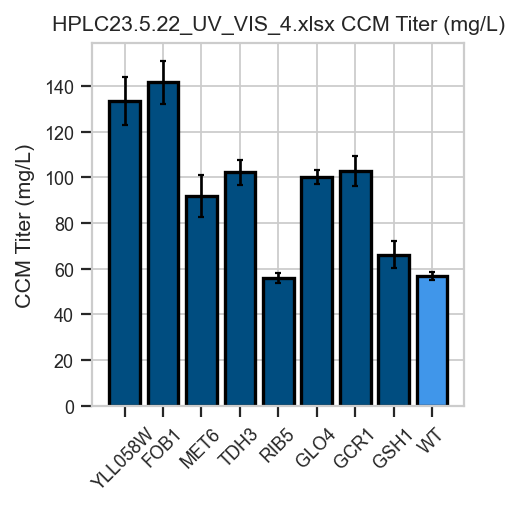

In [16]:
X_YKO=[]
Y_YKO=[]
genes = ['YLL058W','FOB1','MET6','TDH3','RIB5', 'GLO4', 'GCR1','GSH1','WT']


i= (HPLC_CCM['gene'].str.contains('WT'))
WT_score = HPLC_CCM['Amount'][i].values.astype(str)
WT_score = [s.replace(',','.') if ',' in s else s for s in WT_score ]
WT_score = np.stack(WT_score  ).astype(float)

for g in  genes:#4,  3,5,6,4,7,8
    X_YKO.append(g)
    i= (HPLC_CCM['gene'].str.contains(g))#
    y = HPLC_CCM['Amount'][i].values.astype(str)        #this one liner replaces commas to dots 
    y = [s.replace(',','.') if ',' in s else s for s in y ]    
    y=np.stack(y).astype(float)
    gene_score = y[np.isnan(y)==0] #ignore nans
   # print(np.mean(gene_score)/ np.mean(WT_score),np.mean(gene_score), np.mean(WT_score))
    t, p = ttest_ind(gene_score, WT_score)
    print(g,y, p)
    Y_YKO.append(y)

Y_YKO = np.stack(Y_YKO).astype(float)*dilution_factor


H =3
fig, ax = plt.subplots(figsize=(H,H))


colors=[Top_color,Top_color,Top_color,Top_color,Top_color,Top_color,Top_color,Top_color,WT_color]
#ax.bar(np.arange(Y_YKO.shape[0]) ,Y_YKO.mean(axis=1),yerr=Y_YKO.std(axis=1),
   #    color=colors,edgecolor= edgecolor,linewidth=3,ecolor=edgecolor,capsize=5)

ax.bar(np.arange(Y_YKO.shape[0]) ,Y_YKO.mean(axis=1),yerr=Y_YKO.std(axis=1),
       color=colors,edgecolor= edgecolor,linewidth=H/2,ecolor=edgecolor,capsize=H/2)
ax.xaxis.set_ticks(np.arange(Y_YKO.shape[0]))


ax.tick_params(axis='both', which='major', labelsize=H*2.7)
ax.set_ylabel('CCM Titer (mg/L)')
ax.set_xticklabels(X_YKO,rotation = 45, size=H*2.7)
#ax.set_xlim([0, 400])
ax.tick_params(axis='x',labelsize=H*2.7)
ax.tick_params(axis='y',labelsize=H*2.7)

ax.set_title(hplc_file +' CCM Titer (mg/L)')
plt.show()
